In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cascade-cup-22/sample_submission.csv
/kaggle/input/cascade-cup-22/train.csv
/kaggle/input/cascade-cup-22/test.csv


# Preface:
* > **I've tried to describe the end-to-end process our team adopted for this problem, from feature engineering to hyperparameter tuning and model predictions. It's a fairly modest rank we've achieved with this, hence personally looking forward to read through some of the top rankers' approaches.**
* > **Feel free to comment for constructive discussions, alternatives or criticisms. Looking forward!**
* > **And if you learnt something new you appreciate, do consider upvoting at your discretion!**

# Importing Data and Dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.feature_selection import chi2
import xgboost as xgb
xgb.set_config(verbosity=0)
import lightgbm as lgb
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score

import optuna
import sys
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [3]:
#For NaN imputation - Multivariate imputer
!git clone https://github.com/analokmaus/kuma_utils.git
sys.path.append('kuma_utils/')
from kuma_utils.preprocessing.imputer import LGBMImputer

Cloning into 'kuma_utils'...
remote: Enumerating objects: 895, done.
remote: Counting objects: 100% (611/611), done.
remote: Compressing objects: 100% (429/429), done.
remote: Total 895 (delta 379), reused 393 (delta 172), pack-reused 284
Receiving objects: 100% (895/895), 694.50 KiB | 2.92 MiB/s, done.
Resolving deltas: 100% (566/566), done.


In [4]:
train_data = pd.read_csv('../input/cascade-cup-22/train.csv')
test_data = pd.read_csv('../input/cascade-cup-22/test.csv')
train_data

,order_time,order_id,order_date,allot_time,accept_time,pickup_time,delivered_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,cancelled_time
0,2021-01-26 02:21:35,556753,2021-01-26 00:00:00,2021-01-26 02:21:59,2021-01-26 02:22:08,2021-01-26 02:32:51,2021-01-26 02:49:47,11696,1.5666,2.65,46.0,46.0,0,0.0,621.0,NaN,NaN,NaN,NaN,NaN
1,2021-01-26 02:33:16,556754,2021-01-26 00:00:00,2021-01-26 02:33:57,2021-01-26 02:34:45,2021-01-26 02:50:25,2021-01-26 03:11:15,18117,2.5207,2.76,8.0,8.0,0,0.0,105.0,NaN,NaN,NaN,3.266667,NaN
2,2021-01-26 02:39:49,556755,2021-01-26 00:00:00,2021-01-26 02:39:57,2021-01-26 02:40:13,2021-01-26 02:56:00,2021-01-26 03:12:46,18623,2.2074,4.80,1.0,1.0,0,0.0,66.0,NaN,NaN,NaN,9.816667,NaN
3,2021-01-26 02:47:53,556756,2021-01-26 00:00:00,2021-01-26 02:48:25,2021-01-26 02:49:06,2021-01-26 03:21:51,2021-01-26 03:41:05,15945,2.1894,6.38,1.0,1.0,0,0.0,127.0,NaN,NaN,NaN,17.533333,NaN
4,2021-01-26 03:06:30,556757,2021-01-26 00:00:00,2021-01-26 03:07:21,2021-01-26 03:07:57,2021-01-26 03:31:38,2021-01-26 04:00:15,17589,2.7870,4.01,34.0,34.0,0,0.0,84.0,NaN,NaN,NaN,1.350000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449995,2021-02-06 10:03:16,130226,2021-02-06 00:00:00,2021-02-06 10:03:44,2021-02-06 10:04:14,2021-02-06 10:27:29,2021-02-06 10:44:08,1006,0.5789,0.19,4.0,4.0,0,0.0,127.0,NaN,NaN,NaN,369.516667,NaN
449996,2021-02-06 10:03:17,130227,2021-02-06 00:00:00,2021-02-06 10:03:18,2021-02-06 10:04:34,2021-02-06 10:22:17,2021-02-06 10:31:43,279,1.9863,1.19,81.0,81.0,0,0.0,105.0,NaN,NaN,NaN,239.133333,NaN
449997,2021-02-06 10:03:18,130228,2021-02-06 00:00:00,2021-02-06 10:04:06,2021-02-06 10:04:39,2021-02-06 10:19:06,2021-02-06 10:26:56,3161,1.5944,1.61,28.0,28.0,0,0.0,1488.0,NaN,NaN,NaN,204.150000,NaN
449998,2021-02-06 10:03:19,130229,2021-02-06 00:00:00,2021-02-06 10:03:19,2021-02-06 10:05:41,2021-02-06 10:20:39,2021-02-06 10:30:41,9396,2.8939,4.68,72.0,72.0,0,0.0,105.0,NaN,NaN,NaN,65.583333,NaN


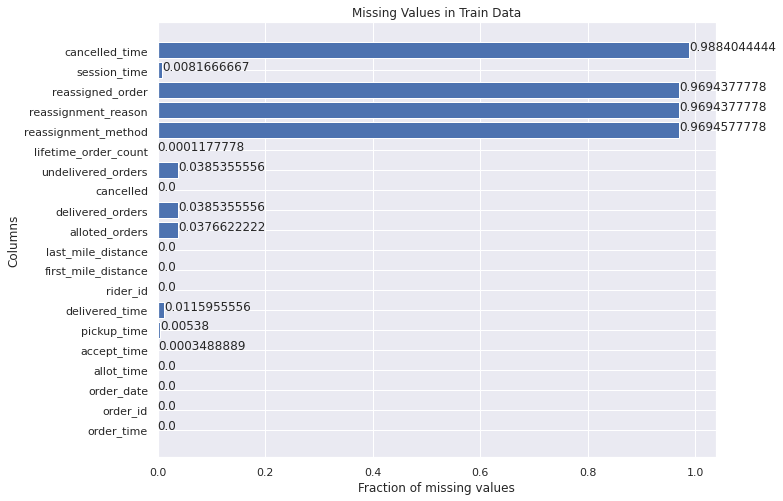

In [5]:
cols = [train_data.columns[i] for i in range(len(train_data.columns))]
missing = [train_data[col].isnull().sum() / len(train_data) for col in cols]
plt.figure(figsize=(10,8))
plt.barh(cols, missing)
plt.title('Missing Values in Train Data')
plt.ylabel('Columns')
plt.xlabel('Fraction of missing values')
for index, value in enumerate(missing):
    plt.text(value, index, str(round(value,10)))

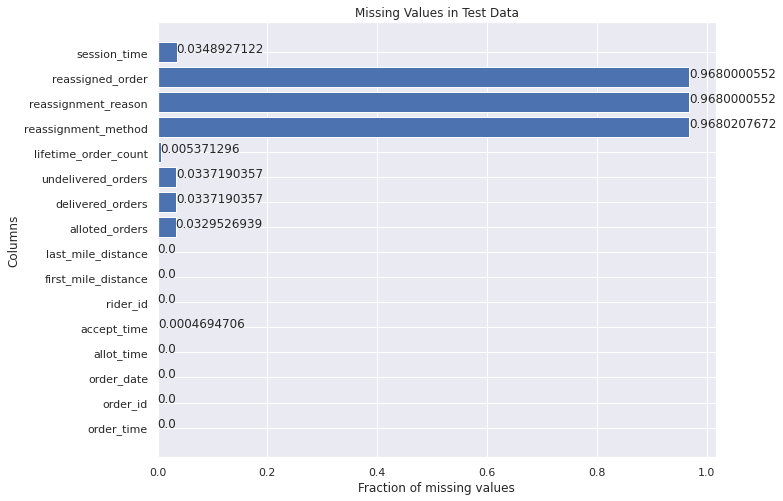

In [6]:
cols = [test_data.columns[i] for i in range(len(test_data.columns))]
missing = [test_data[col].isnull().sum() / len(test_data) for col in cols]
plt.figure(figsize=(10,8))
plt.barh(cols, missing)
plt.title('Missing Values in Test Data')
plt.ylabel('Columns')
plt.xlabel('Fraction of missing values')
for index, value in enumerate(missing):
    plt.text(value, index, str(round(value,10)))

<AxesSubplot:xlabel='cancelled', ylabel='count'>

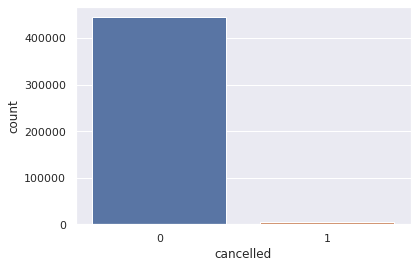

In [7]:
sns.countplot(x = train_data['cancelled'])

# Feature Extraction

In [8]:
print('Values in REASSIGNED_ORDER: contains 1 and NaNs')
print('Output label when 1:')
print(train_data['cancelled'][train_data['reassigned_order'] == 1].value_counts())
print('Output label when NaN:')
print(train_data['cancelled'][train_data['reassigned_order'].isnull()].value_counts())

Values in REASSIGNED_ORDER: contains 1 and NaNs
Output label when 1:
0    13031
1      722
Name: cancelled, dtype: int64
Output label when NaN:
0    431751
1      4496
Name: cancelled, dtype: int64


In [9]:
#Encoding missing values as 0 class, all other points are 1
test_data['reassigned_order'].fillna(0, inplace=True)
train_data['reassigned_order'].fillna(0, inplace=True)

test_data['reassignment_method'].fillna(0, inplace=True)
train_data['reassignment_method'].fillna(0, inplace=True)
train_data['reassignment_method'].replace({'auto':1, 'manual':2}, inplace=True)
test_data['reassignment_method'].replace({'auto':1, 'manual':2}, inplace=True)

#Time variable, contains missing values, can't be used for feature extraction, hence encoded as 0: NaN, 1: others. 
#Interestingly, all NaN values correspond to target label of 1, which is an extreme minority class.
test_data['accept_time'].fillna(0, inplace=True)
train_data['accept_time'].fillna(0, inplace=True)
train_data.loc[train_data['accept_time'] != 0, 'accept_time'] = 1
test_data.loc[test_data['accept_time'] != 0, 'accept_time'] = 1

encoder = LabelEncoder()
train_data['accept_time'] = encoder.fit_transform(train_data['accept_time'].astype(str))
test_data['accept_time'] = encoder.transform(test_data['accept_time'].astype(str))

In [10]:
#Handling time based features
def convert_to_datetime(datetime_str):
    #get time string in datetime format
    return datetime.fromisoformat(datetime_str)

def prepare_time_data(df):
    df['order_time'] = df['order_time'].apply(convert_to_datetime)
    df['allot_time'] = df['allot_time'].apply(convert_to_datetime)
    #Day of month: numerical
    df['order_DoM'] = df['order_time'].dt.day 
    #Month: nominal
    df['order_month'] = df['order_time'].dt.month
    #Hour: numerical
    df['order_hour'] = df['order_time'].dt.hour
    #Day of week: nominal
    df['order_DoW'] = df['order_time'].dt.weekday
    #Subtracting time to get delay bw order receipt and allotment to rider, in seconds
    df['allot_delay'] = df['allot_time'] - df['order_time']
    df['allot_delay'] = df['allot_delay']/timedelta(seconds=1)
    return df

train_data = prepare_time_data(train_data)
test_data = prepare_time_data(test_data)

In [11]:
#Dropping used or unnecessary columns
train_drop_cols = ['reassignment_reason', 'order_id', 'pickup_time', 'delivered_time', 'cancelled_time', 'order_date', 'order_time', 'allot_time','cancelled']
test_drop_cols = ['reassignment_reason', 'order_id', 'order_date', 'order_time', 'allot_time']
ids = test_data['order_id']
y_train = train_data['cancelled']
train_data.drop(train_drop_cols, axis=1, inplace=True)
test_data.drop(test_drop_cols, axis=1, inplace=True)

# Feature Selection

<AxesSubplot:>

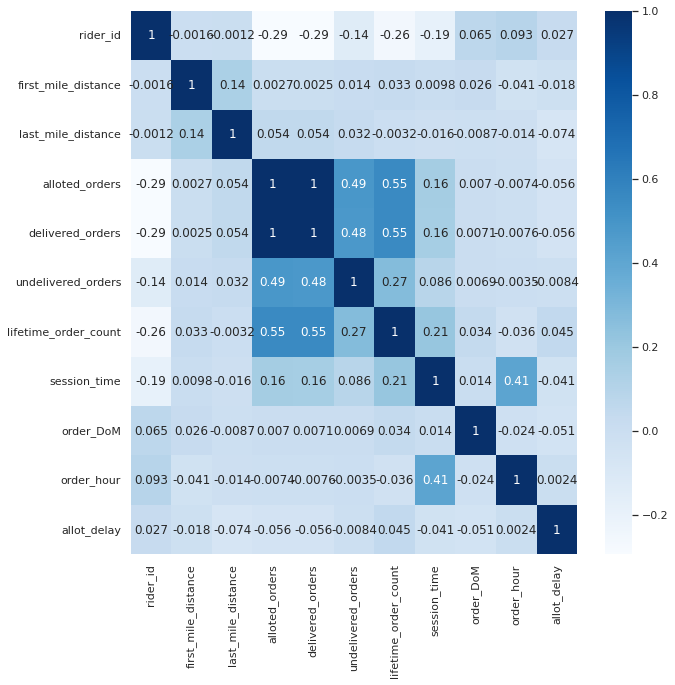

In [12]:
#Correlation heatmap for numerical feature selection and removing collinearity
categorical = ['reassigned_order', 'reassignment_method', 'order_DoW', 'order_month', 'accept_time']
numerical = [col for col in train_data.columns if col not in categorical]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(train_data[numerical].corr(method='spearman'), cmap='Blues', annot=True, ax=ax)

In [13]:
#chi2 test To determine relation between cateogorical features and target.
#H0: No relationship between the two. Based on obtained p-values, we can safely reject Null Hypo, and use all features except for order_month (0.0553)
print(chi2(train_data[categorical], y_train))

(array([2007.52983444, 2149.2492148 ,   26.15038996,    3.67172751,
          4.67069455]), array([0.00000000e+00, 0.00000000e+00, 3.15833319e-07, 5.53427951e-02,
       3.06815171e-02]))


In [14]:
#Dropping due to correlation=1 in above heatmap and chi2 test p-value
train_data.drop(['alloted_orders'], axis=1, inplace=True)
test_data.drop(['alloted_orders'], axis=1, inplace=True)
numerical.remove('alloted_orders')

# Hyperparameter Optimization and Model Training

In [15]:
#Using optuna for tuning hyperparameters. Uncomment and run the cell for the same.
#Since the trials are not reproducible, the obtained optimal hyperparams were hard-coded into the model after running this.
"""X_tr, X_val, y_tr, y_val = train_test_split(train_data, y_train, test_size=0.1, random_state=42)
imputer = LGBMImputer(verbose=True, n_iter=250)
train_imp = imputer.fit_transform(X_tr)
val_imp = imputer.transform(X_val)
X_tr = pd.DataFrame(data=train_imp, columns=X_tr.columns)
X_val = pd.DataFrame(data=val_imp, columns=X_val.columns)
scaler = RobustScaler()
X_tr[numerical] = scaler.fit_transform(X_tr[numerical])
X_val[numerical] = scaler.transform(X_val[numerical])
def xgb_objective(trial):
    tune_params = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 20000),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'lr': trial.suggest_float('eta', 0.001, 0.1),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-4, 1e4),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1e4),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1e4),
        'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4)
    }
    clf = xgb.XGBClassifier(eval_metric='auc', use_label_encoder=False, tree_method='gpu_hist', predictor='gpu_predictor', **tune_params)
    clf.fit(X_tr, y_tr)
    y_probs = clf.predict_proba(X_val)[:,1]
    return roc_auc_score(y_val, y_probs)

study = optuna.create_study(direction="maximize")
study.optimize(xgb_objective, n_trials=150)
print(f'Best hyperparams: {study.best_params}')"""

'X_tr, X_val, y_tr, y_val = train_test_split(train_data, y_train, test_size=0.1, random_state=42)\nimputer = LGBMImputer(verbose=True, n_iter=250)\ntrain_imp = imputer.fit_transform(X_tr)\nval_imp = imputer.transform(X_val)\nX_tr = pd.DataFrame(data=train_imp, columns=X_tr.columns)\nX_val = pd.DataFrame(data=val_imp, columns=X_val.columns)\nscaler = RobustScaler()\nX_tr[numerical] = scaler.fit_transform(X_tr[numerical])\nX_val[numerical] = scaler.transform(X_val[numerical])\ndef xgb_objective(trial):\n    tune_params = {\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 1000, 20000),\n        \'max_depth\': trial.suggest_int(\'max_depth\', 3, 7),\n        \'subsample\': trial.suggest_float(\'subsample\', 0.3, 1.0),\n        \'colsample_bytree\': trial.suggest_float(\'colsample_bytree\', 0.3, 1.0),\n        \'lr\': trial.suggest_float(\'eta\', 0.001, 0.1),\n        \'min_child_weight\': trial.suggest_loguniform(\'min_child_weight\', 1e-4, 1e4),\n        \'reg_lambda\': tria

In [16]:
#Optimized from above: only reg_lambda manually tweaked to 100
hyperparams = {
    'n_estimators': 4224, 'max_depth': 4, 'subsample': 0.8228095102142363, 'colsample_bytree': 0.7231288353109224, 
    'eta': 0.03354525014836744, 'min_child_weight': 0.2564075050900551, 'reg_lambda': 100, 
    'reg_alpha': 0.23410280083265067, 'gamma': 2.8516989547505136}

# Prediction and Submission

In [17]:
#Predicting over Stratified 10-folds using above hyperparams and using OOF probabilities for submission.
kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
test_probs = []
val_scores = []
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_data, y_train)):
    X_train = train_data.iloc[train_idx]
    y_tr = y_train.iloc[train_idx]
    X_val = train_data.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    imputer = LGBMImputer(verbose=True, n_iter=250)
    train_imp = imputer.fit_transform(X_train)
    val_imp = imputer.transform(X_val)
    test_imp = imputer.transform(test_data)
    X_train = pd.DataFrame(data=train_imp, columns=X_train.columns)
    X_val = pd.DataFrame(data=val_imp, columns=X_val.columns)
    test = pd.DataFrame(data=test_imp, columns=test_data.columns)
    scaler = RobustScaler()
    X_train[numerical] = scaler.fit_transform(X_train[numerical])
    X_val[numerical] = scaler.transform(X_val[numerical])
    test[numerical] = scaler.transform(test[numerical])

    clf = xgb.XGBClassifier(eval_metric='auc', 
                            use_label_encoder=False,
                            tree_method='gpu_hist',
                            **hyperparams, 
                            random_state=fold)
    
    clf.fit(X_train, y_tr, eval_set=[(X_val, y_val)], verbose=False)
    y_val_probs = clf.predict_proba(X_val)[:,1]
    val_roc = roc_auc_score(y_val, y_val_probs)
    val_scores.append(val_roc)
    print(f'Fold: {fold} ---- val_score: {val_roc}')
    test_probs.append(clf.predict_proba(test)[:,1])
    
print(f'Mean Validation Score: {np.mean(val_scores)}')

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Fold: 0 ---- val_score: 0.7714440194533778


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Fold: 1 ---- val_score: 0.7600315946290339


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Fold: 2 ---- val_score: 0.7503225366572375


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Fold: 3 ---- val_score: 0.7445511397515565


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Fold: 4 ---- val_score: 0.7696698044700389


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Fold: 5 ---- val_score: 0.7758856718350059


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Fold: 6 ---- val_score: 0.7517302884597991


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Fold: 7 ---- val_score: 0.7834908997155423


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Fold: 8 ---- val_score: 0.7587269671742661


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Fold: 9 ---- val_score: 0.7423577095844361
Mean Validation Score: 0.7608210631730294


In [18]:
#Averaging the final probability scores for all test points across the 10 folds.
df = pd.DataFrame()
df['order_id'] = ids
df['cancelled'] = np.mean(np.column_stack(test_probs),axis=1)
df.to_csv('Submission.csv', index=False)
df.head()

,order_id,cancelled
0,130231,0.005443
1,130232,0.006429
2,130233,0.003396
3,130234,0.006519
4,130235,0.003351
